In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    'go',
    'back',
    'start',
    'finish'
]

data = np.concatenate([
    np.load('dataset/seq_go_1628424713.npy'),
    np.load('dataset/seq_back_1628424713.npy'),
    np.load('dataset/seq_start_1628424713.npy'),
    np.load('dataset/seq_finish_1628424713.npy')
], axis=0)

data.shape

(3393, 30, 100)

In [3]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(3393, 30, 99)
(3393,)


In [4]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(3393, 4)

In [5]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(3053, 30, 99) (3053, 4)
(340, 30, 99) (340, 4)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                41984     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 44,196
Trainable params: 44,196
Non-trainable params: 0
_________________________________________________________________


In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
96/96 [==============================] - 2s 10ms/step - loss: 12.0697 - acc: 0.3616 - val_loss: 12.1583 - val_acc: 0.4294

Epoch 00001: val_acc improved from -inf to 0.42941, saving model to models\model.h5
Epoch 2/200
96/96 [==============================] - 1s 8ms/step - loss: 5.9814 - acc: 0.5378 - val_loss: 1.5161 - val_acc: 0.6912

Epoch 00002: val_acc improved from 0.42941 to 0.69118, saving model to models\model.h5
Epoch 3/200
96/96 [==============================] - 1s 10ms/step - loss: 1.4732 - acc: 0.7036 - val_loss: 1.8625 - val_acc: 0.6353

Epoch 00003: val_acc did not improve from 0.69118
Epoch 4/200
96/96 [==============================] - 1s 10ms/step - loss: 6.7518 - acc: 0.4687 - val_loss: 8.1253 - val_acc: 0.5118

Epoch 00004: val_acc did not improve from 0.69118
Epoch 5/200
96/96 [==============================] - 1s 9ms/step - loss: 4.1377 - acc: 0.5480 - val_loss: 2.2365 - val_acc: 0.5676

Epoch 00005: val_acc did not improve from 0.69118
Epoch 6/200
96

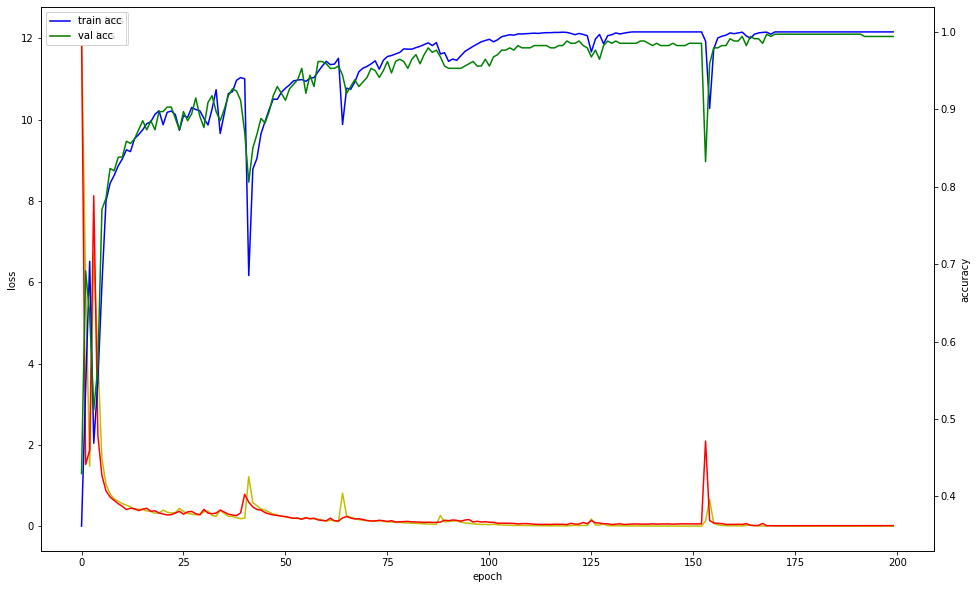

In [8]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [9]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[236,   0],
        [  0, 104]],

       [[263,   0],
        [  0,  77]],

       [[263,   1],
        [  0,  76]],

       [[257,   0],
        [  1,  82]]], dtype=int64)